IST 707 – Applied Machine Learning - Syracuse University - 03/15/2023

Mathew D. Smith, Sintia Stabel


## Machine Learning for Stock Prediction

The price of stocks is influenced by a complex interplay of various factors. Company-specific performance, economic conditions, political events, interest rates, and unpredictable external forces all play a significant role in determining the value of stocks. Positive news such as product launches and good quarterly earnings can cause prices to surge, while negative news and unexpected events can lead to sharp declines. Given the vast amount of information and influence from various sources, making investment decisions can be challenging. Even experts in the field often struggle to predict the future of the stock market with a high degree of accuracy, as it remains an inherently volatile and unpredictable space. As such, investors should take a comprehensive and careful approach to their investments, balancing risk and reward while keeping up with market trends and developments.

Experienced trading professionals understand that there are numerous ways to trade the stock markets successfully. However, despite many claims of overnight success stories or a single algorithm that can guarantee profits, the reality is that stock prices are determined by more than just financial statements and forecasts. While data-driven approaches are important, the role of human perception and emotions cannot be ignored. If making money in the stock market was as simple as finding a single winning strategy or relying purely on mathematical models, the world's smartest mathematicians and computer scientists would already have become billionaires. Therefore, it is important to recognize that understanding market psychology and emotional biases is crucial to successful trading.

Machine learning and AI have significantly improved our ability to predict the future price of stocks. However, due to the complex and unpredictable nature of financial markets and external factors, these models are still not infallible. This report examines the effectiveness of various machine learning models in predicting future stock prices, with the goal of providing traders and investment enthusiasts with an edge. It is important to note that there is no one-size-fits-all approach when it comes to selecting the best model for a particular stock or market. Each model has its own set of strengths and weaknesses, and determining the best approach requires careful consideration of market conditions, data availability, and other relevant factors. It's essential to remember that the models and algorithms presented in this report are not intended as professional investment advice and should not be taken as recommendations for future investments. Investors should always conduct their own research and consult with a financial advisor before making investment decisions.


### Analysis and Models

#### About the Data


Various stock price time series data have been downloaded from Yahoo Finance (www.yahoofinance.com), a website that provides free stock price data available for download. The following stock symbols and indexes have been downloaded and used during the analysis: "AMZN","MSFT","INTC","GOOG". In addition, Dow Jones Industrial Average csv data sets with 5 years historical daily Open, High, Low, and Close prices (02/21/2014 to 02/20/2019) were downloaded from the Kaggle website(https://www.kaggle.com/datasets/timoboz/stock-data-dow-jones)

The data sets have been manipulated to have additional features, mostly in the form mathematical indicators to aid the model performance: RSI, Bollinger Bands, Simple Moving Average, MACD, On Balance Volume, and Sharpe Ratio. All “NA” or missing values have been removed. 


In [73]:
# Importing all pertinent libraries 
import pandas as pd
import numpy as np
import glob
import os
import datetime as dt
import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from numpy.random import seed
from ta.trend import EMAIndicator
from ta.momentum import RSIIndicator
from ta.trend import MACD
plt.style.use('fivethirtyeight')

In [7]:
# Reading the Dow Jones Industrial Average files
files = glob.glob("./csv_dowjones/*csv")
files

['./csv_dowjones\\AAPL.csv',
 './csv_dowjones\\AXP.csv',
 './csv_dowjones\\BA.csv',
 './csv_dowjones\\CAT.csv',
 './csv_dowjones\\CSCO.csv',
 './csv_dowjones\\CVX.csv',
 './csv_dowjones\\DIS.csv',
 './csv_dowjones\\DWDP.csv',
 './csv_dowjones\\GS.csv',
 './csv_dowjones\\HD.csv',
 './csv_dowjones\\IBM.csv',
 './csv_dowjones\\INTC.csv',
 './csv_dowjones\\JNJ.csv',
 './csv_dowjones\\JPM.csv',
 './csv_dowjones\\KO.csv',
 './csv_dowjones\\MCD.csv',
 './csv_dowjones\\MMM.csv',
 './csv_dowjones\\MRK.csv',
 './csv_dowjones\\MSFT.csv',
 './csv_dowjones\\NKE.csv',
 './csv_dowjones\\PFE.csv',
 './csv_dowjones\\PG.csv',
 './csv_dowjones\\TRV.csv',
 './csv_dowjones\\UNH.csv',
 './csv_dowjones\\UTX.csv',
 './csv_dowjones\\V.csv',
 './csv_dowjones\\VZ.csv',
 './csv_dowjones\\WBA.csv',
 './csv_dowjones\\WMT.csv',
 './csv_dowjones\\XOM.csv']

The below code iterates over each of the files from the Dow Jones data set, combining all csv files into a single data frame. It uses a "try except to skip on errors” and sets the stock symbol as the index.

In [8]:
# Create an empty list to hold the data frames
data_frames = []

# Loop through the list of file names
for filename in files:
    try:
        # Read the CSV file into a data frame, skipping any rows with errors
        df = pd.read_csv(filename, index_col=None, header=0, on_bad_lines='skip')
        # Add a new column to the data frame with the file name
        df['filename'] = os.path.basename(filename)
        # Append the data frame to the list
        data_frames.append(df)
    except pd.errors.ParserError as e:
        print(f"Error parsing {filename}: {e}")

# Combine the data frames into a single data frame
combined_df = pd.concat(data_frames, ignore_index=True)

# Set the index to the 'filename' column
combined_df.set_index('filename', inplace=True)

combined_df.head(3)

date     open     high      low    close    volume  \
filename                                                             
AAPL.csv  2014-02-21  69.9727  70.2061  68.8967  68.9821  69757247   
AAPL.csv  2014-02-24  68.7063  69.5954  68.6104  69.2841  72364950   
AAPL.csv  2014-02-25  69.5245  69.5488  68.4239  68.5631  58247350   

          unadjustedVolume    change  changePercent     vwap       label  \
filename                                                                   
AAPL.csv           9965321 -0.774858         -1.111  69.4256  Feb 21, 14   
AAPL.csv          10337850  0.302061          0.438  69.1567  Feb 24, 14   
AAPL.csv           8321050 -0.721010         -1.041  68.9153  Feb 25, 14   

          changeOverTime  
filename                  
AAPL.csv        0.000000  
AAPL.csv        0.004378  
AAPL.csv       -0.006074

In [9]:
combined_df.info() #checking for number of rows and columns

<class 'pandas.core.frame.DataFrame'>
Index: 36850 entries, AAPL.csv to XOM.csv
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              36850 non-null  object 
 1   open              36850 non-null  float64
 2   high              36850 non-null  float64
 3   low               36850 non-null  float64
 4   close             36850 non-null  float64
 5   volume            36850 non-null  int64  
 6   unadjustedVolume  36850 non-null  int64  
 7   change            36850 non-null  float64
 8   changePercent     36850 non-null  float64
 9   vwap              36850 non-null  float64
 10  label             36850 non-null  object 
 11  changeOverTime    36850 non-null  float64
dtypes: float64(8), int64(2), object(2)
memory usage: 3.7+ MB


In [10]:
# Adding variables and selecting columns to use

# Calculate percent change
combined_df['pct_change'] = combined_df['close'].pct_change()

# Calculate monthly mean return
combined_df['mean_return'] = combined_df['close'].pct_change(periods=251) * 251

# Calculate monthly variance
combined_df['variance'] = combined_df['close'].rolling(251).var() * 251

# getting only pertinent columns
combined_df = combined_df[['close','mean_return','variance','pct_change']]


# Print the updated dataframe
combined_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 36850 entries, AAPL.csv to XOM.csv
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close        36850 non-null  float64
 1   mean_return  36599 non-null  float64
 2   variance     36600 non-null  float64
 3   pct_change   36849 non-null  float64
dtypes: float64(4)
memory usage: 1.4+ MB


In [11]:
combined_df.dropna(inplace=True) # dropping missing values permanentantely

In [12]:
combined_df.head()

close  mean_return      variance  pct_change
filename                                                 
AAPL.csv  120.7286   188.286113  44610.780550    0.008136
AAPL.csv  123.9963   198.209433  45294.067165    0.027066
AAPL.csv  123.2225   200.100483  45870.749941   -0.006241
AAPL.csv  120.0713   192.565733  46201.157864   -0.025573
AAPL.csv  121.5863   189.378143  46661.418479    0.012618

#### Models

Maintaining a diversified portfolio is crucial for successful stock trading. A well-diversified portfolio is important for risk management, as it reduces the impact of market volatility by spreading investments across different stocks, industries, and sectors. Diversification helps to minimize the risk of significant losses when a particular sector or stock experiences a downturn. Additionally, a diversified portfolio can help maximize returns by increasing the chances of capturing gains from different areas of the market. Even if some stocks are performing poorly, others may be doing exceptionally well, ensuring the long-term growth of the portfolio as a whole. 

K-means clustering is a widely used unsupervised machine learning algorithm that can aid in stock price diversification. The algorithm groups stocks with similar price trends into distinct clusters by assigning each stock to the cluster whose centroid is closest to it in terms of Euclidean distance. Euclidean distance is a geometric distance metric that calculates the distance between two points in n-dimensional space. It is calculated as the square root of the sum of the squared differences between each corresponding coordinate of the two points. Once the stocks belonging to different clusters have been identified, investors can use this information to diversify their portfolios, by investing in a variety of stocks across the different clusters.

To test the K-means algorithm for stock diversification, the stocks from the Dow Jones Industrial Average (DJIA) were used. The DJIA is a stock market index that tracks the performance of 30 large, publicly traded companies in the United States, representing a diverse range of industries, including finance, technology, and healthcare.

In [13]:
# Get and show the labels or groups for each stock:
# Running K-means with 10 centroids

X = combined_df[['close','mean_return','variance','pct_change']].values

kmeans = KMeans(n_clusters = 10).fit(X)
labels = kmeans.labels_
labels

array([3, 3, 3, ..., 3, 3, 3])

In [14]:
# Countting the number of unique elements in the array
unique_elements = len(np.unique(labels))

# printting the result
print("There are", unique_elements, "different numbers in the array.")

There are 10 different numbers in the array.


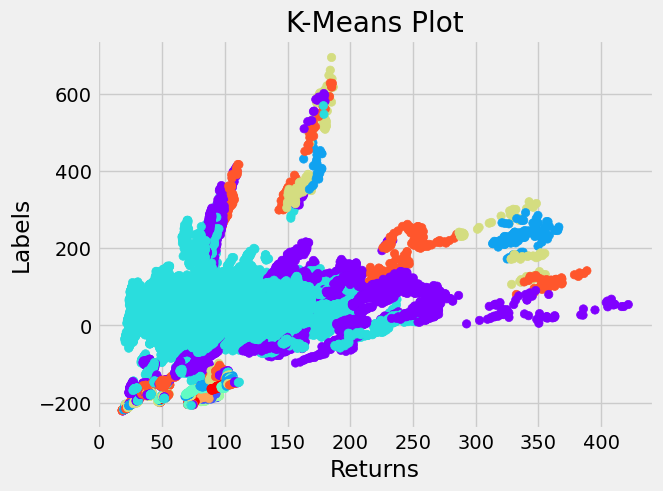

In [15]:
# Plotting the clusters
plt.scatter(X[:,0],X[:,1], c = labels, cmap = "rainbow")
plt.title("K-Means Plot")
plt.xlabel('Returns')
plt.ylabel("Labels")

plt.show()

In [16]:
# Adding labels to data set for stock identification
combined_df['cluster_labels'] = labels
combined_df.head()

close  mean_return      variance  pct_change  cluster_labels
filename                                                                 
AAPL.csv  120.7286   188.286113  44610.780550    0.008136               3
AAPL.csv  123.9963   198.209433  45294.067165    0.027066               3
AAPL.csv  123.2225   200.100483  45870.749941   -0.006241               3
AAPL.csv  120.0713   192.565733  46201.157864   -0.025573               3
AAPL.csv  121.5863   189.378143  46661.418479    0.012618               3

After performing an aggregation of the counts of labels per stock, its clear that some stocks were placed in many different clusters. CAT has features distributed across all 10 clusters. However, there were a number of stocks that had most features put in a single cluster. For example: AXP is mostly in cluster 0 with only a 38 data points assigned to label 9, so AXP could safely be placed in cluster 0. In any case during this run of k-means, most of the stock’s data points were assigned to labels 0 or 9. This probably means that 10 centroids may not be ideal for the DJIA group of stocks. 

In [17]:
# Aggragating the total counts with a pivot table
combined_df_pivot = combined_df.pivot_table(index="filename", columns=['cluster_labels'], values=['close'], aggfunc='count')
combined_df_pivot.head()

close                                                      \
cluster_labels      0     1      2       3     4     5     6     7      8   
filename                                                                    
AAPL.csv        304.0   NaN    NaN   703.0   NaN   NaN   NaN   NaN    NaN   
AXP.csv          39.0   NaN   98.0  1015.0   NaN   NaN  51.0   NaN   55.0   
BA.csv          176.0   NaN  101.0   764.0   NaN   NaN  79.0   NaN  138.0   
CAT.csv         170.0  56.0    9.0   840.0  10.0  90.0   6.0  48.0    4.0   
CSCO.csv         24.0   NaN  116.0  1013.0   NaN   NaN  65.0   NaN   40.0   

                      
cluster_labels     9  
filename              
AAPL.csv         NaN  
AXP.csv          NaN  
BA.csv           NaN  
CAT.csv         25.0  
CSCO.csv         NaN

Determining the optimal number of centroids is essential to obtaining meaningful results with K-means. The Elbow method is one way to determine the best number of centroids. It involves plotting the number of centroids against the Within-Cluster-Sum-of-Squares (WCSS), which measures the variance within each cluster. The point on the plot where adding another centroid does not significantly decrease the WCSS is referred to as the "elbow point."

The KneeLocator function was used to find the point of maximum curvature in the elbow curve, which corresponds to the optimal number of clusters.

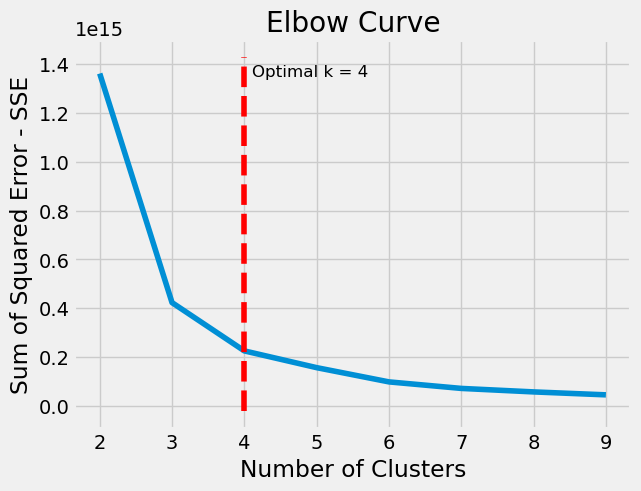

The optimal number of clusters is: 4


In [18]:
from kneed import KneeLocator

X = combined_df[['close','mean_return','variance','pct_change']].values
inertia_list = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertia_list.append(kmeans.inertia_)

# Finding the optimal number of clusters
kn = KneeLocator(range(2, 10), inertia_list, curve='convex', direction='decreasing')
optimal_k = kn.knee

# Plotting the elbow curve
plt.plot(range(2, 10), inertia_list)
plt.title("Elbow Curve")
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Error - SSE')
plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red')
plt.text(optimal_k+0.1, plt.ylim()[1]*0.9, 'Optimal k = %d' % optimal_k, fontsize=12)
plt.show()

print("The optimal number of clusters is:", optimal_k)

In [19]:
# Running K-means with 4 Centroids
kmeans = KMeans(n_clusters = 4).fit(X)
labels = kmeans.labels_

# Countting the number of unique elements in the array
unique_elements = len(np.unique(labels))

# printting the result
print("There are", unique_elements, "different numbers in the array.")

There are 4 different numbers in the array.


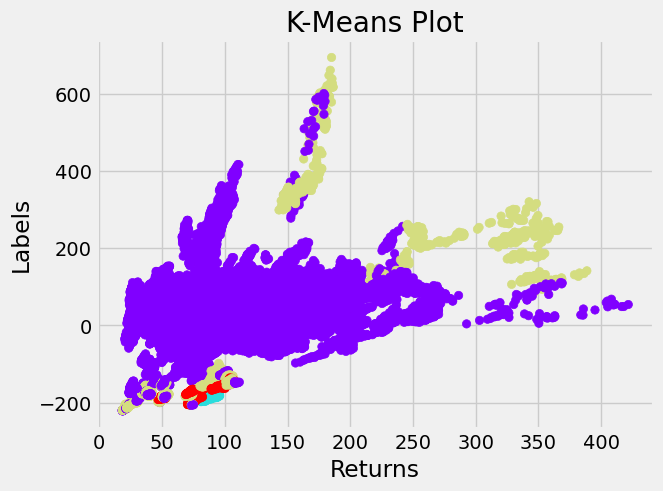

In [20]:
# Plotting the clusters
plt.scatter(X[:,0],X[:,1], c = labels, cmap = "rainbow")
plt.title("K-Means Plot")
plt.xlabel('Returns')
plt.ylabel("Labels")

plt.show()

Running the K-means algorithm with 4 centroids formed 4 separate clusters, but once again at close inspection, the stocks’ data points were mostly allocated to cluster 0. However, one way to use these results, would be putting the stocks that had a portion of their data points segregated to a different cluster in a separate portfolio from the stocks that had all their data points allocated to cluster 0. 

In [21]:
# Adding labels to data set for stock identification
combined_df['cluster_labels'] = labels

# Aggragating the total counts with a pivot table
combined_df_pivot = combined_df.pivot_table(index="filename",columns=['cluster_labels'], values=['close'], aggfunc='count')
combined_df_pivot.head(10)

close                     
cluster_labels       0      1      2      3
filename                                   
AAPL.csv        1007.0    NaN    NaN    NaN
AXP.csv         1075.0    NaN  183.0    NaN
BA.csv           979.0    NaN  279.0    NaN
CAT.csv         1012.0  170.0   16.0   60.0
CSCO.csv        1049.0    NaN  209.0    NaN
CVX.csv         1258.0    NaN    NaN    NaN
DIS.csv         1258.0    NaN    NaN    NaN
DWDP.csv         368.0    NaN    NaN    NaN
GS.csv           963.0    NaN  295.0    NaN
HD.csv          1032.0    NaN  119.0  107.0

To further illustrate how k-means works to separate stocks in clusters based on their distinct characteristics, the algorithm was applied to 3 other stocks that belong to different industries and have their main activities focused on different products and services. Stock prices from Toyota Motors, Coca Cola, and Google were dowloaded from Yahoo Finance. 

In [22]:
# Toyota Motors = TM
# Coca Cola = KO
# Google  = GOOGL

# Define the list of tickers to download data for
tickers = ['TM', 'KO', 'GOOGL']

# Download the historical data for each ticker from Yahoo Finance
df_list = []
for ticker in tickers:
    df = yf.download(ticker, start='2018-01-01', end='2022-03-01')
    df['ticker'] = ticker
    df_list.append(df)

# Combine the data for all tickers into a single DataFrame
combined_df = pd.concat(df_list)

# Compute the features
combined_df['mean_return'] = combined_df['Close'].pct_change().rolling(window=20).mean()
combined_df['variance'] = combined_df['Close'].pct_change().rolling(window=20).var()
combined_df['pct_change'] = combined_df['Close'].pct_change()

combined_df.dropna(inplace=True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


The same variables mean_return, variance and pct_change were added to the dataset. The number of centroids was set to 3 to see if k-means would assign the data points to the correct labels. The K-means plot shows 3 distinct clusters, and the pivot aggregation confirms that the majority of the data points were assigned correctly to the appropriate labels. 

In [23]:
# Set a random seed for reproducibility
np.random.seed(42)

# Select the features to use for clustering
X = combined_df[['Close', 'mean_return', 'variance', 'pct_change']].values

# Perform k-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_


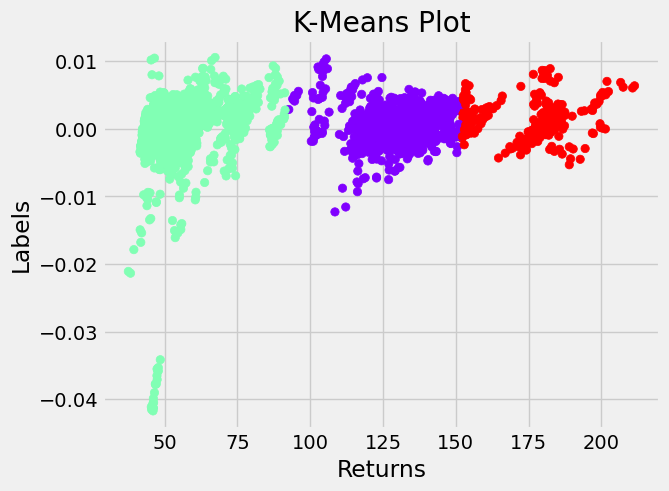

In [24]:
# Plotting the clusters
plt.scatter(X[:,0],X[:,1], c = labels, cmap = "rainbow")
plt.title("K-Means Plot")
plt.xlabel('Returns')
plt.ylabel("Labels")

plt.show()

In [25]:
# Adding labels to data set for stock identification
combined_df['cluster_labels'] = labels

# Aggragating the total counts with a pivot table
combined_df_pivot = combined_df.pivot_table(index="ticker",columns=['cluster_labels'], values=['Close'], aggfunc='count')
combined_df_pivot.head(10)

Close               
cluster_labels      0       1      2
ticker                              
GOOGL           278.0   769.0    NaN
KO                NaN  1047.0    NaN
TM              763.0     NaN  264.0

### K-nearest neighbors (KNN)

K-Nearest Neighbors is a popular non-parametric supervised machine learning algorithm that can be used for stock prediction. KNN predicts the value of a new data point based on the values of its k-nearest neighbors in the training set. The value of k is a hyperparameter that is typically chosen based  on the size and complexity of the data set. For stock prediction, the algorithm is first trained using historical prices along with other features such as indicators. The algorithm then finds the k-nearest neighbors of a new data point in the feature space, based on similarity metric such as Euclidean distance. The predicted value of the new “target closing price” is calculated as the average of that target variable value of its k-nearest neighbors. 

KNN can be a useful tool for stock prediction because it can handle complex patterns in the data and adapt to changing market conditions. As with any machine learning model, the performance of KNN will depend on the quality of the training set and the choice of hyperparameters. For this instance, Google historical prices were downloaded, and the additional features/hyperparameters were added in the form of commonly used indicators such as EMA, RSI, and MACD, as new columns to the data set.

Below is the plot of a candlestick bar chart of the Google daily stock price data. It shows the daily open, high, low, and close prices of the stock. Green bars are a representation of prices closing higher than the open price, while red means the prices moved downward and closed below the open price.  Traders want to predict the closing price of a bar to capitalize on the price movement. For example, buying stock near the open or lowest price and selling near the predicted closing price, would result in  profits based on the difference between the two, if the prediction pointed to a closing price higher that the precious day.

[*********************100%***********************]  1 of 1 completed


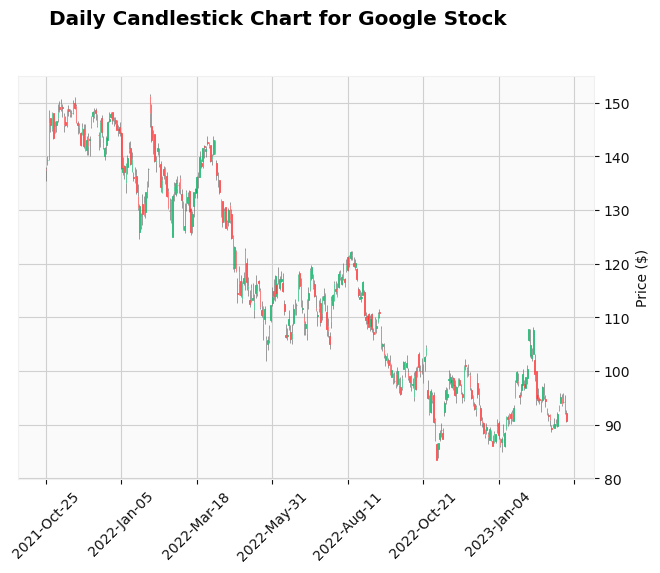

In [106]:
# Download the historical data for Google stock from Yahoo Finance with 1 day interval for the last 504 days
ticker = "GOOGL"
start_date = dt.datetime.now() - dt.timedelta(days=504)
end_date = dt.datetime.now()
df = yf.download(ticker, start=start_date, end=end_date, interval='1d')

# Create a new DataFrame with the high, low, open, and close prices
df_hloc = df[['High', 'Low', 'Open', 'Close']]

# Clean the data by dropping any missing values and keeping only the "Close" column
df = df.dropna()
df = df[['Close']]

# Add the EMA, RSI, and MACD indicators as new columns to the DataFrame
ema = EMAIndicator(df['Close'], window=20)
df['EMA'] = ema.ema_indicator()

rsi = RSIIndicator(df['Close'], window=14)
df['RSI'] = rsi.rsi()

macd = MACD(df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['MACD'] = macd.macd()

# Create a new column for the target variable by shifting the "Close" column up by one day
df['Target'] = df[['Close']].shift(-1)

# Drop any remaining missing values
df.dropna(inplace=True)
# Plot the candlestick chart
mpf.plot(df_hloc, type='candle', volume=False, style='yahoo', 
         title=' Daily Candlestick Chart for Google Stock', ylabel='Price ($)')

Before applying KNN to predict the Google closing prices, the GridSearchCV function from the scikit-learn library was used to perform a grid search for hyperparameter tuning. It exhaustively searches over a specified parameter grid to find the best combination of hyperparameters for a given model and dataset. It then performs a fit on the training data using every possible combination of hyperparameters in the grid and evaluates the performance of each model using cross-validation. After the grid search is complete, the function returns a GridSearchCV object, which includes attributes such as the best hyperparameters found, the best model performance score. The function found that n-neighbors = 7 had the best overall score. 

In [107]:
# Split the data into training and testing sets using an 80/20 split and a random seed for reproducibility

np.random.seed(42)
X = np.array(df.drop(columns=['Target']))
y = np.array(df['Target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameters to tune
param_grid = {'n_neighbors': [1, 3, 5, 7, 9]}

# Create a grid search object and fit it to the training data
knn = KNeighborsRegressor()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

Best Hyperparameters: {'n_neighbors': 7}
Best Score: 8.331923486325401


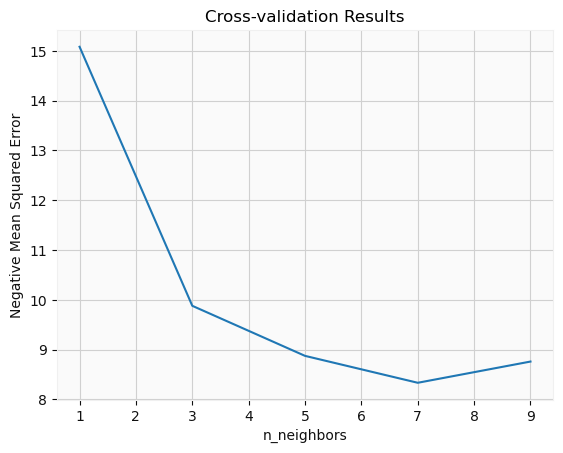

In [108]:
# PLotting the cross-validation results
results = grid_search.cv_results_
scores = -results['mean_test_score']
params = results['param_n_neighbors']

# Plot the scores as a function of n_neighbors
plt.plot(params, scores)
plt.xlabel('n_neighbors')
plt.ylabel('Negative Mean Squared Error')
plt.title('Cross-validation Results')
plt.show()

KNN with k = 7, or 7 n-neighbors, which is the number of “neighbors” that were set up for training the model, produced a mean standard error(MSE) of 6.33, and an absolute error(ASE) of 1.95. The lower the MSE and ASE scores, the more accurate the model. MSE is the average squared difference between the predicted and actual values, while ASE is the amount that the predicted values are off by on average. That means that on average, the predicted values for the predicted Google closing prices were off by $1.95 dollars.

The plot below is showing the actual results in blue, the predicted in green and the EMA in red. RSI is plotted in a subplot to show thresholds of overbought and oversold. 

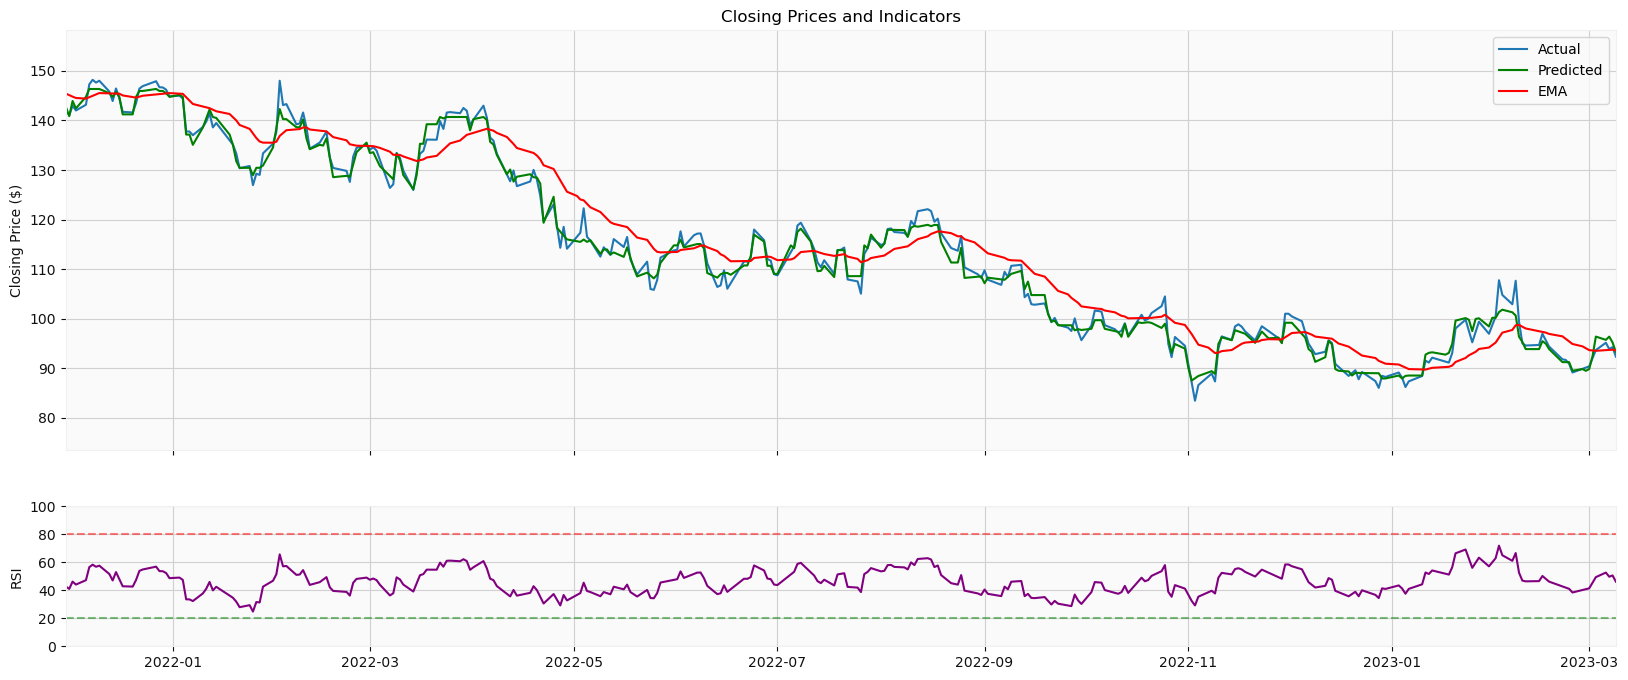

Mean squared error: 6.334057946406297
Absolute standard error: 1.9485968181065156


In [110]:
# KNN over Google daily data using n_neighbors: 7

# Train the KNN model on the training dataset
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train, y_train)

# Predict the closing prices for the test dataset
y_pred = knn.predict(X_test)

# Calculate the mean squared error and absolute standard error
mse = mean_squared_error(y_test, y_pred)
ase = np.mean(np.abs(y_pred - y_test))

# Plot the actual closing prices, predicted closing prices, and the indicators on the same chart
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(20, 8))

# Plot the actual closing prices and the predicted closing prices
axs[0].plot(df.index, df['Close'], label='Actual')
axs[0].plot(df.index, knn.predict(X), label='Predicted', color='green')
axs[0].plot(df.index, df['EMA'], label='EMA', color='red')
axs[0].set_title('Closing Prices and Indicators')
axs[0].set_ylabel('Closing Price ($)')
axs[0].set_ylim([min(df['Close'])-10, max(df['Close'])+10])
axs[0].legend()

# Plot the RSI indicator
axs[1].plot(df.index, df['RSI'], label='RSI', color='purple')
axs[1].axhline(y=80, color='red', linestyle='--', alpha=0.5)
axs[1].axhline(y=20, color='green', linestyle='--', alpha=0.5)
axs[1].set_ylabel('RSI')
axs[1].set_xlim([df.index[0], df.index[-1]])
axs[1].set_ylim([0, 100])

# Show the plot
plt.show()

print("Mean squared error:", mse)
print("Absolute standard error:", ase)

The following code shows the relative feature importance from each of the variables used by KNN in order of highest to lowest. The closing price is the most significant variable in determining the predicted closing prices, followed by the exponential moving average (EMA). MACD had no impact in reducing the overall MSE score.

In [82]:

# Train the KNN model on the training dataset
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train, y_train)

# Use permutation feature importance to determine the most important features
result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=42)

# Print the feature importance scores
for i in result.importances_mean.argsort()[::-1]:
    print(f"{df.columns[i]}: {result.importances_mean[i]:.3f}")

Close: 0.603
EMA: 0.418
RSI: 0.033
MACD: 0.000


Next a Principal Component Analysis (PCA) was applied to see if by diminishing the dimensionality of the data would improve the results from the previous run. PCA selects the most important features while retaining the most variability.  It functions as a “noise” reducer. However, to achieve best results a scaler is applied to standardize the features to have zero mean and unit variance. The built-in StandardScaler from the scikit-learn package’s was used. 

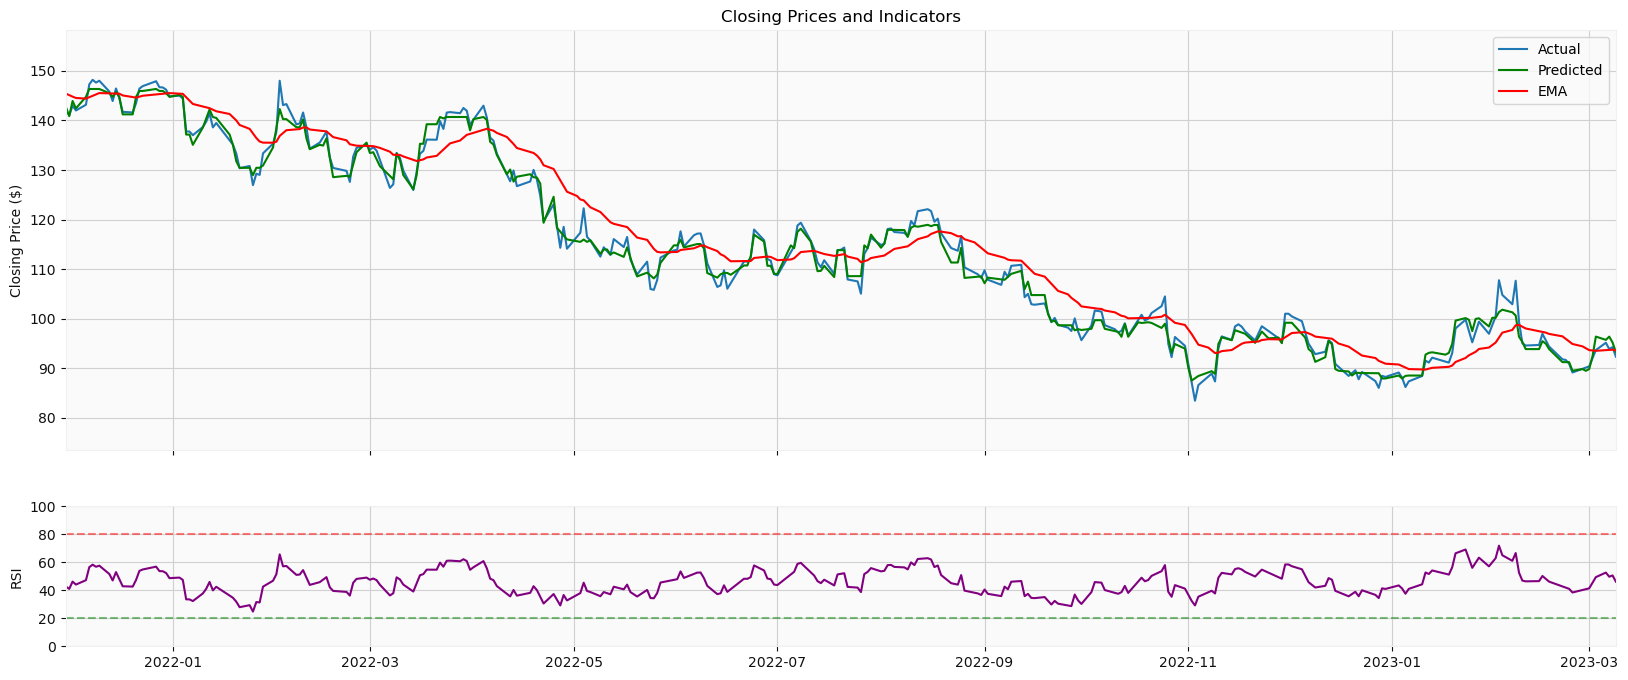

Mean squared error: 6.334057946406297
Absolute standard error: 1.9485968181065156


In [114]:

# Set a random seed for reproducibility
np.random.seed(42)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(['Target'], axis=1))

# Apply PCA
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)


# Split the data into training and testing sets using an 80/20 split and a random seed for reproducibility
X = np.array(df.drop(columns=['Target']))
y = np.array(df['Target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataFrames for the training and test datasets
df_train = df.iloc[:len(X_train)]
df_test = df.iloc[len(X_train):]
# Train the KNN model on the training dataset
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train, y_train)

# Predict the closing prices for the test dataset
y_pred = knn.predict(X_test)

# Calculate the mean squared error and absolute standard error
mse = mean_squared_error(y_test, y_pred)
ase = np.mean(np.abs(y_pred - y_test))
# Plot the actual closing prices, predicted closing prices, and the indicators on the same chart
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(20, 8))

# Plot the actual closing prices and the predicted closing prices
axs[0].plot(df.index, df['Close'], label='Actual')
axs[0].plot(df.index, knn.predict(X), label='Predicted', color='green')
axs[0].plot(df.index, df['EMA'], label='EMA', color='red')
axs[0].set_title('Closing Prices and Indicators')
axs[0].set_ylabel('Closing Price ($)')
axs[0].set_ylim([min(df['Close'])-10, max(df['Close'])+10])
axs[0].legend()

# Plot the RSI indicator
axs[1].plot(df.index, df['RSI'], label='RSI', color='purple')
axs[1].axhline(y=80, color='red', linestyle='--', alpha=0.5)
axs[1].axhline(y=20, color='green', linestyle='--', alpha=0.5)
axs[1].set_ylabel('RSI')
axs[1].set_xlim([df.index[0], df.index[-1]])
axs[1].set_ylim([0, 100])

# Show the plot
plt.show()

print("Mean squared error:", mse)
print("Absolute standard error:", ase)

No change was observed after applying PCA. The same number of features was kept, which can be expected since the data set does not contain a high number of variables. 

In [115]:
#Check the number of features before and after PCA

print(f"Number of features before PCA: {X.shape[1]}")
print(f"Number of features after PCA: {X_pca.shape[1]}")

Number of features before PCA: 4
Number of features after PCA: 4


#### Applying KNN to Google stock using 60 min bars

The same features were applied to the 60 min bars.

In [123]:

# Download the historical data for Google stock from Yahoo Finance with 60 minute interval for last 252 days
ticker = "GOOGL"
start_date = dt.datetime.now() - dt.timedelta(days=252)
end_date = dt.datetime.now()
df = yf.download(ticker, start=start_date, end=end_date, interval='60m')

# Clean the data by dropping any missing values and keeping only the "Close" column
df = df.dropna()
df = df[['Close']]

# Add the EMA, RSI, and MACD indicators as new columns to the DataFrame
ema = EMAIndicator(df['Close'], window=20)
df['EMA'] = ema.ema_indicator()

rsi = RSIIndicator(df['Close'], window=14)
df['RSI'] = rsi.rsi()

macd = MACD(df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['MACD'] = macd.macd()

# Create a new column for the target variable by shifting the "Close" column up by one hour
df['Target'] = df[['Close']].shift(-1)


# Drop any remaining missing values from the indicator calculations
df.dropna(inplace=True)

# Showing the Target column which is the column being predicted in the test run
df.tail()

[*********************100%***********************]  1 of 1 completed


Close        EMA        RSI      MACD     Target
Datetime                                                                 
2023-03-10 10:30:00  92.324997  93.571429  39.562627 -0.354378  91.959999
2023-03-10 11:30:00  91.959999  93.417960  37.339704 -0.431341  91.349998
2023-03-10 12:30:00  91.349998  93.221011  33.910466 -0.535385  90.589996
2023-03-10 13:30:00  90.589996  92.970438  30.190291 -0.671427  90.916801
2023-03-10 14:30:00  90.916801  92.774854  33.565362 -0.744290  90.629997

 Finding the best value for K prior to testing the model:

In [124]:
# Split the data into training and testing sets using an 80/20 split and a random seed for reproducibility
# Determining the best number for K

np.random.seed(42)

X = np.array(df.drop(columns=['Target']))
y = np.array(df['Target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameters to tune
param_grid = {'n_neighbors': [1, 3, 5, 7, 9]}

# Create a grid search object and fit it to the training data
knn = KNeighborsRegressor()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

Best Hyperparameters: {'n_neighbors': 5}
Best Score: 1.09837166550668


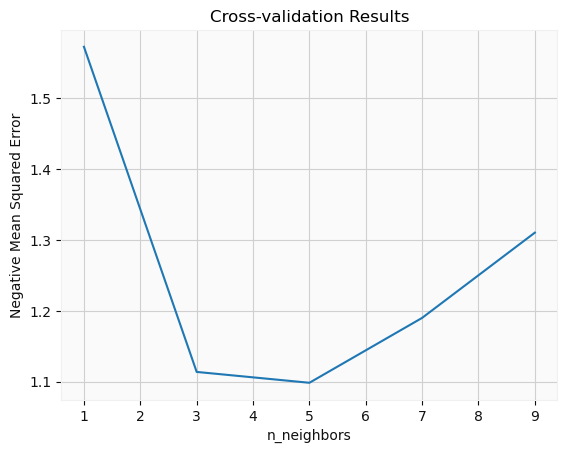

In [125]:
# PLotting the cross-validation results
results = grid_search.cv_results_
scores = -results['mean_test_score']
params = results['param_n_neighbors']

# Plot the scores as a function of n_neighbors
plt.plot(params, scores)
plt.xlabel('n_neighbors')
plt.ylabel('Negative Mean Squared Error')
plt.title('Cross-validation Results')
plt.show()

Using 60 min data produce much better results. The MSE dropped from 6.33 to 1.29 and the ASE score was 0.79. This means the predictions were within an average of $ 0.79 cents from the actual closing prices. 

In [126]:
# Running KNN with 5 n-neighbors with the 60 min Data

# Set a random seed for reproducibility
np.random.seed(42)

# Split the data into training and testing sets using an 80/20 split
X = np.array(df.drop(columns=['Target']))
y = np.array(df['Target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

# Train the KNN model on the training set
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# Test the KNN model on the testing set and calculate the mean squared error and absolute standard error
y_pred = knn.predict(X_test)
mse = np.mean((y_pred - y_test) ** 2)
ase = np.mean(np.abs(y_pred - y_test))
print("Mean squared error:", mse)
print("Absolute standard error:", ase)

Mean squared error: 1.2934643015331393
Absolute standard error: 0.799693298339844


The plot below is showing the actual results in blue, the predicted in green and the EMA in red. RSI is plotted in a subplot to show thresholds of overbought and oversold. The importance of each variable is also listed, with Close and EMA still coming up as the most important features for the predictions.

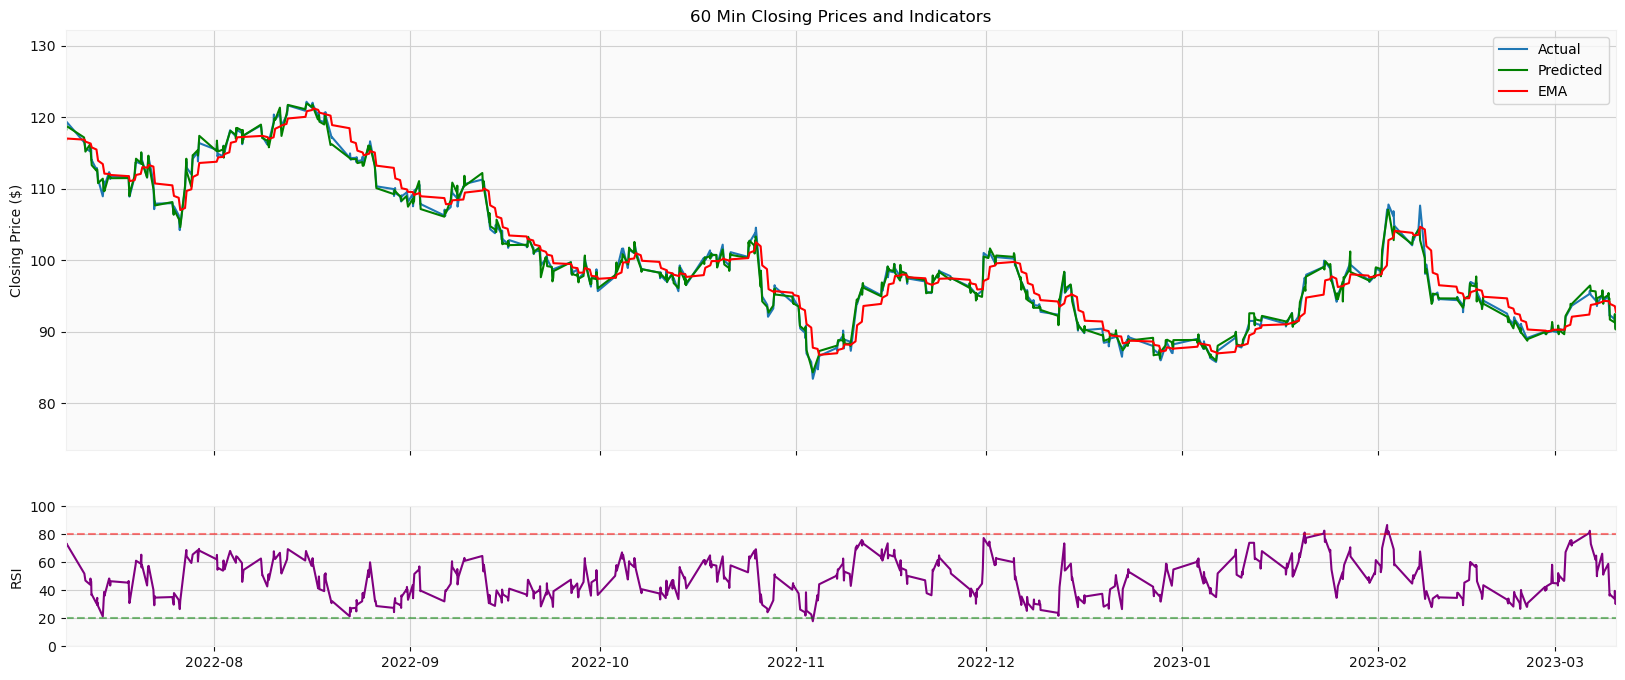

Mean squared error: 1.2934643015331393
Absolute standard error: 0.799693298339844
Close: 0.556
EMA: 0.420
RSI: 0.017
MACD: 0.000


In [127]:

# Plot the actual closing prices, predicted closing prices, and the indicators on the same chart
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(20, 8))

# Plot the actual closing prices and the predicted closing prices
axs[0].plot(df.index, df['Close'], label='Actual')
axs[0].plot(df.index, knn.predict(X), label='Predicted', color='green')
axs[0].plot(df.index, df['EMA'], label='EMA', color='red')
axs[0].set_title('60 Min Closing Prices and Indicators')
axs[0].set_ylabel('Closing Price ($)')
axs[0].set_ylim([min(df['Close'])-10, max(df['Close'])+10])
axs[0].legend()

# Plot the RSI indicator
axs[1].plot(df.index, df['RSI'], label='RSI', color='purple')
axs[1].axhline(y=80, color='red', linestyle='--', alpha=0.5)
axs[1].axhline(y=20, color='green', linestyle='--', alpha=0.5)
axs[1].set_ylabel('RSI')
axs[1].set_xlim([df.index[0], df.index[-1]])
axs[1].set_ylim([0, 100])

# Show the plot
plt.show()

print("Mean squared error:", mse)
print("Absolute standard error:", ase)


# Use permutation feature importance to determine the most important features
result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=42)

# Print the feature importance scores
for i in result.importances_mean.argsort()[::-1]:
    print(f"{df.columns[i]}: {result.importances_mean[i]:.3f}")

In [121]:
# Add the predicted test values back to the original DataFrame as a new column named 'Predicted'
df['Predicted'] = np.nan
df.iloc[-len(y_pred):, df.columns.get_loc('Predicted')] = y_pred
df = df[['Close','Target','Predicted']]
df.tail()

Close     Target   Predicted
Datetime                                             
2023-03-10 10:30:00  92.324997  91.959999  118.225981
2023-03-10 11:30:00  91.959999  91.349998  100.014001
2023-03-10 12:30:00  91.349998  90.589996   87.417700
2023-03-10 13:30:00  90.589996  90.916801  113.747809
2023-03-10 14:30:00  90.916801  90.629997   94.545999

### Long Short -Term Memory (LSTM)

LSTM (Long Short-Term Memory) is popular machine learning model for stock prediction because it uses Recurrent Neural Networks (RNN) to capture the temporal dependencies of the input data that are present in time series data. The key feature of RNN is its ability to maintain a "memory" or "state" of previous inputs, which is in turn used to inform the processing of the current input. This is achieved through a series of repeating neural network blocks, each of which takes an input vector and produces an output vector, as well as a hidden state vector that is passed on to the next block. The output of each block is determined by the input and the hidden state vector, which serves as a "memory" of the previous inputs. This feedback loop allows the network to learn and recognize sequential patterns in the data.

Past price movements are often indicative of future price movements for stock predictions, which means that LSTM’s ability to take into account what it learns from a previous time step, is a tremendous advantage in predicting the future price. Furthermore, LSTM has the ability to capture long-term dependencies in sequential data, which is crucial for stock price prediction since stock prices are influenced by a wide range of factors that can have a long-term impact. 

In [129]:
# Re-setting the data to daily

# Download the historical data for Google stock from Yahoo Finance with 60 minute interval for last 504 days
ticker = "GOOGL"
start_date = dt.datetime.now() - dt.timedelta(days=504)
end_date = dt.datetime.now()
df = yf.download(ticker, start=start_date, end=end_date, interval='1d')

# Clean the data by dropping any missing values and keeping only the "Close" column
df = df.dropna()
df = df[['Close']]

# Add the EMA, RSI, and MACD indicators as new columns to the DataFrame
ema = EMAIndicator(df['Close'], window=20)
df['EMA'] = ema.ema_indicator()

rsi = RSIIndicator(df['Close'], window=14)
df['RSI'] = rsi.rsi()

macd = MACD(df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['MACD'] = macd.macd()

# Create a new column for the target variable by shifting the "Close" column up by one hour
df['Target'] = df[['Close']].shift(-1)


# Drop any remaining missing values from the indicator calculations
df.dropna(inplace=True)



[*********************100%***********************]  1 of 1 completed


Prior to running the model on Google daily data, the variables were scaled to numbers between 0 and 1 to improve processing time, as neural networks are sensitive to input scale. If the data is not scaled, input features with a larger scale may dominate the training process, making it difficult for the network to learn from the smaller-scale features. Scaling can also help to normalize the input data, which can be especially important when working with time-series data. Normalization can help to remove any trends or seasonal effects in the data, making it easier to identify the underlying patterns and relationships.

The model was run using 10 epochs over 80% of the data. In machine learning, an epoch refers to one complete iteration through the entire training dataset. The number of epochs must be optimized to achieve best performance, while keeping in mind that if the number of epochs is too high, the model may be overfitted. It is common practice to use early stopping during training, if the validation error starts to increase, which is an indication that the model is overfitting the training data.

After the run, the model produced a MSE of 7.75 and a MAE of 2.05. The plot shows the predicted values in orange are following the same pattern as the actual values but with a significant distance still. This suggests the model has room for improvement. 

Epoch 1/10
196/196 [==============================] - 7s 20ms/step - loss: 0.0100
Epoch 2/10
196/196 [==============================] - 4s 21ms/step - loss: 0.0078
Epoch 3/10
196/196 [==============================] - 4s 21ms/step - loss: 0.0062
Epoch 4/10
196/196 [==============================] - 4s 21ms/step - loss: 0.0050
Epoch 5/10
196/196 [==============================] - 4s 20ms/step - loss: 0.0040
Epoch 6/10
196/196 [==============================] - 4s 20ms/step - loss: 0.0038
Epoch 7/10
196/196 [==============================] - 4s 20ms/step - loss: 0.0037
Epoch 8/10
196/196 [==============================] - 4s 22ms/step - loss: 0.0030
Epoch 9/10
196/196 [==============================] - 4s 22ms/step - loss: 0.0028
Epoch 10/10
2/2 [==============================] - 1s 19ms/step


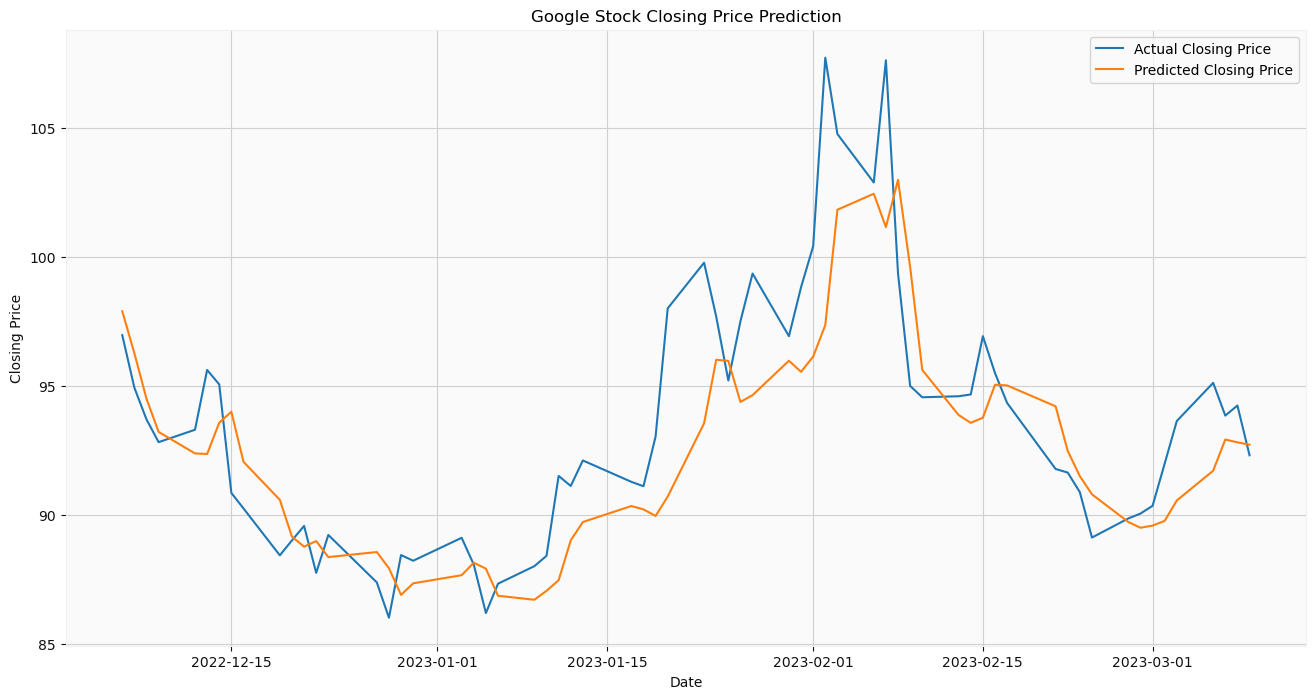

Mean Squared Error (MSE): 7.754048756529301
Mean Absolute Error (MAE): 2.048426389694214


In [37]:
# Create a new dataframe with only the closing price
data = df.filter(['Close'])
# Scale the data to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create the training data and the labels
train_data = scaled_data[0:int(len(data)*0.8)]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert the training data and the labels to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data for LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=10)

# Create the testing data and the labels
test_data = scaled_data[int(len(data)*0.8)-60:]
x_test = []
y_test = data[int(len(data)*0.8):]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the testing data to numpy array
x_test = np.array(x_test)

# Reshape the data for LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Make predictions on the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Plot the predicted over the actual closing price
plt.figure(figsize=(16,8))
plt.plot(df.index[int(len(data)*0.8):], y_test, label='Actual Closing Price')
plt.plot(df.index[int(len(data)*0.8):], predictions, label='Predicted Closing Price')
plt.title('Google Stock Closing Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error
# Calculate the mean squared error and mean absolute error for the LSTM model
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)


Running the same model with 30 epochs produced much tighter results. The MSE dropped from 7.75 to 6.83 and the MAE also dropped from 2.05 to 1.91.

Epoch 1/30
196/196 [==============================] - 10s 29ms/step - loss: 0.0123
Epoch 2/30
196/196 [==============================] - 6s 28ms/step - loss: 0.0066
Epoch 3/30
196/196 [==============================] - 6s 29ms/step - loss: 0.0052
Epoch 4/30
196/196 [==============================] - 6s 29ms/step - loss: 0.0065
Epoch 5/30
196/196 [==============================] - 6s 29ms/step - loss: 0.0046
Epoch 6/30
196/196 [==============================] - 6s 29ms/step - loss: 0.0039
Epoch 7/30
196/196 [==============================] - 5s 27ms/step - loss: 0.0039
Epoch 8/30
196/196 [==============================] - 6s 28ms/step - loss: 0.0037
Epoch 9/30
196/196 [==============================] - 6s 29ms/step - loss: 0.0026
Epoch 10/30
196/196 [==============================] - 6s 28ms/step - loss: 0.0026
Epoch 11/30
196/196 [==============================] - 6s 28ms/step - loss: 0.0028
Epoch 12/30
196/196 [==============================] - 5s 28ms/step - loss: 0.0028
Epoch 13/30


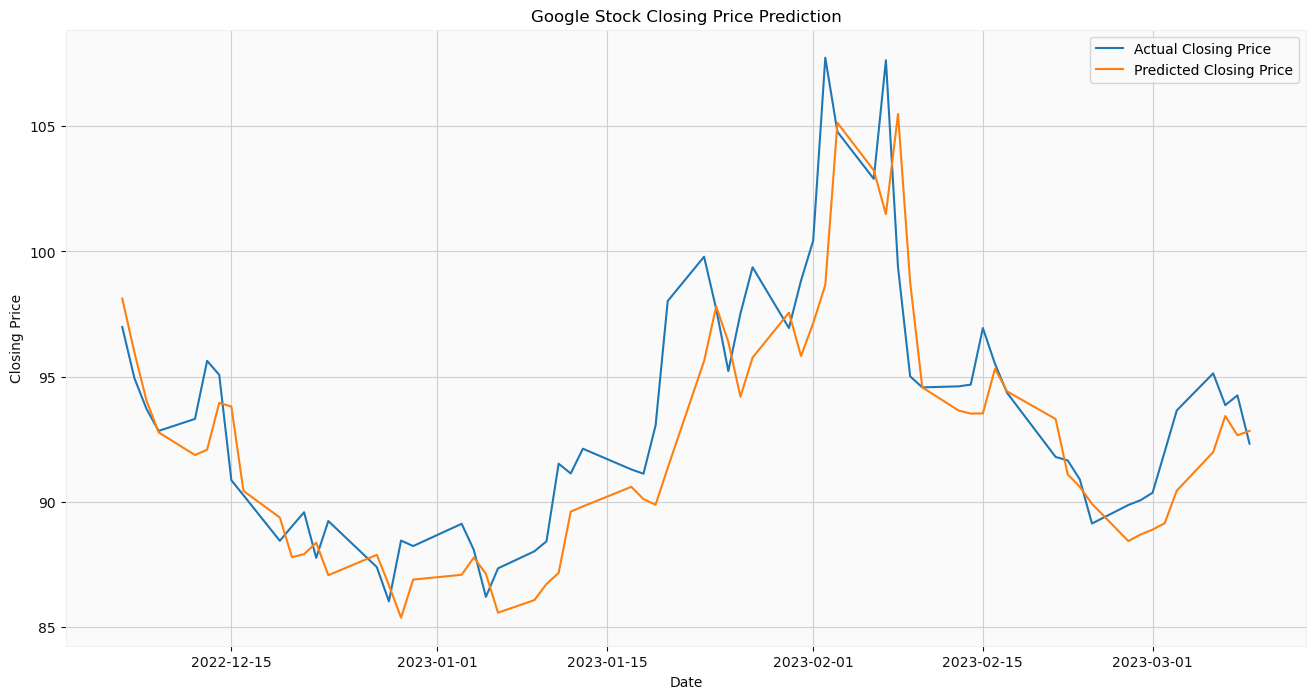

Mean Squared Error (MSE): 6.827271066243156
Mean Absolute Error (MAE): 1.9135619401931763


In [133]:
# Same model with 30 ephocs
# Create a new dataframe with only the closing price

data = df.filter(['Close'])
# Scale the data to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create the training data and the labels
train_data = scaled_data[0:int(len(data)*0.8)]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert the training data and the labels to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data for LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=30)

# Create the testing data and the labels
test_data = scaled_data[int(len(data)*0.8)-60:]
x_test = []
y_test = data[int(len(data)*0.8):]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the testing data to numpy array
x_test = np.array(x_test)

# Reshape the data for LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Make predictions on the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Plot the predicted over the actual closing price
plt.figure(figsize=(16,8))
plt.plot(df.index[int(len(data)*0.8):], y_test, label='Actual Closing Price')
plt.plot(df.index[int(len(data)*0.8):], predictions, label='Predicted Closing Price')
plt.title('Google Stock Closing Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error
# Calculate the mean squared error and mean absolute error for the LSTM model
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

#### Running LSTM with 60 min data

Since previous models performed significantly better using 60 minutes data versus daily data, the LSTM was applied to the Google 60 min data set using 30 epochs. The results showed once again significant improvement when compared to the daily data. MAE dropped from 1.91 to 0.54 and MSE dropped from 2.05 to 0.90. That means an average price of $0.54 cents from the actual price. 

The plot shows the test/predictions in purple versus actual price in blue. 


In [135]:

# Download the historical data for Google stock from Yahoo Finance with 60 minute interval for last 252 days
ticker = "GOOGL"
start_date = dt.datetime.now() - dt.timedelta(days=252)
end_date = dt.datetime.now()
df = yf.download(ticker, start=start_date, end=end_date, interval='60m')

# Clean the data by dropping any missing values and keeping only the "Close" column
df = df.dropna()
df = df[['Close']]

# Add the EMA, RSI, and MACD indicators as new columns to the DataFrame
ema = EMAIndicator(df['Close'], window=20)
df['EMA'] = ema.ema_indicator()

rsi = RSIIndicator(df['Close'], window=14)
df['RSI'] = rsi.rsi()

macd = MACD(df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['MACD'] = macd.macd()

# Create a new column for the target variable by shifting the "Close" column up by one hour
df['Target'] = df[['Close']].shift(-1)


# Drop any remaining missing values from the indicator calculations
df.dropna(inplace=True)


[*********************100%***********************]  1 of 1 completed


In [136]:

# Create a new dataframe with only the closing price
data = df.filter(['Close'])
# Scale the data to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create the training data and the labels
train_data = scaled_data[0:int(len(data)*0.8)]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert the training data and the labels to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data for LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=30)

# Create the testing data and the labels
test_data = scaled_data[int(len(data)*0.8)-60:]
x_test = []
y_test = data[int(len(data)*0.8):]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the testing data to numpy array
x_test = np.array(x_test)

# Reshape the data for LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Make predictions on the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


from sklearn.metrics import mean_absolute_error
# Calculate the mean squared error and mean absolute error for the LSTM model
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)


Epoch 1/30
884/884 [==============================] - 28s 28ms/step - loss: 0.0045
Epoch 2/30
884/884 [==============================] - 24s 27ms/step - loss: 0.0019
Epoch 3/30
884/884 [==============================] - 24s 27ms/step - loss: 0.0013
Epoch 4/30
884/884 [==============================] - 25s 28ms/step - loss: 0.0012
Epoch 5/30
884/884 [==============================] - 27s 30ms/step - loss: 9.9570e-04
Epoch 6/30
884/884 [==============================] - 27s 31ms/step - loss: 9.1659e-04
Epoch 7/30
884/884 [==============================] - 26s 29ms/step - loss: 9.2743e-04
Epoch 8/30
884/884 [==============================] - 25s 29ms/step - loss: 8.7223e-04
Epoch 9/30
884/884 [==============================] - 26s 30ms/step - loss: 7.5605e-04
Epoch 10/30
884/884 [==============================] - 25s 28ms/step - loss: 8.0900e-04
Epoch 11/30
884/884 [==============================] - 26s 30ms/step - loss: 8.0663e-04
Epoch 12/30
884/884 [==============================] - 29

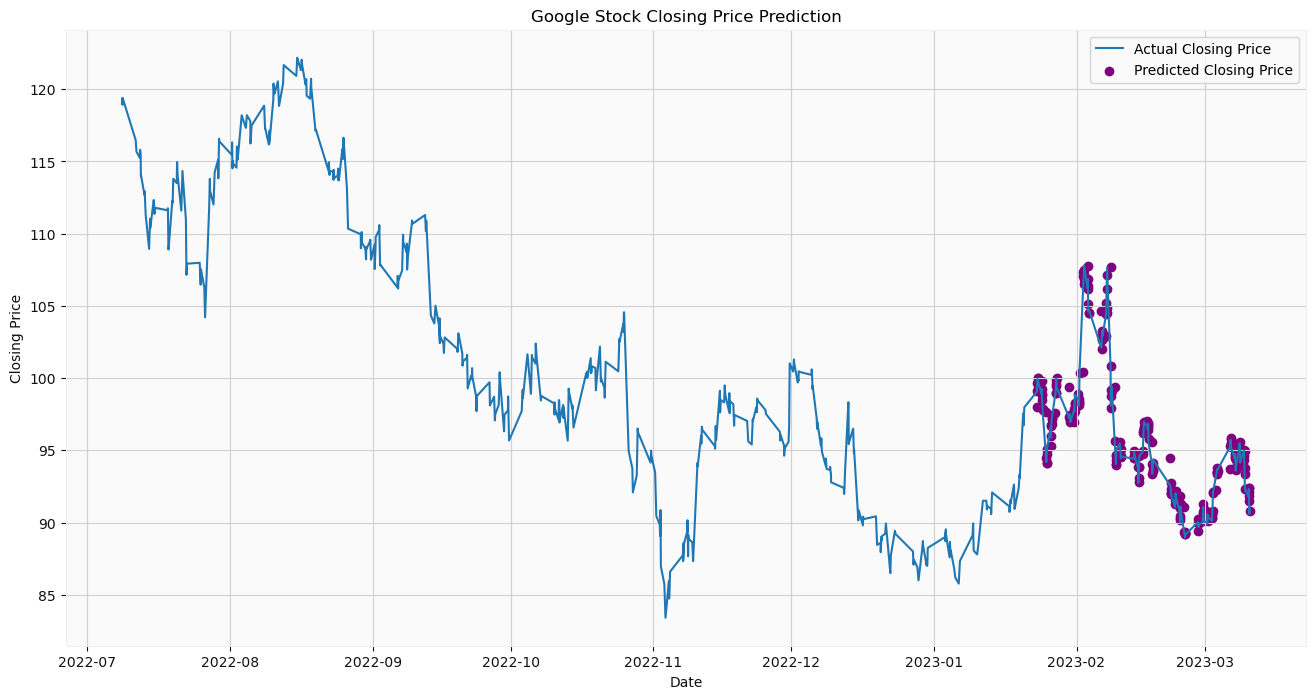

In [143]:
# Create a new column in the data frame for the predicted closing price
df['Predicted Closing Price'] = np.nan
df.iloc[-len(predictions):, df.columns.get_loc('Predicted Closing Price')] = predictions


# Plot the actual and predicted closing prices
plt.figure(figsize=(16,8))
plt.plot(df.index, df['Close'], label='Actual Closing Price')
plt.scatter(df.index[int(len(data)*0.8):], predictions, color = 'purple', label='Predicted Closing Price')
plt.title('Google Stock Closing Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

Closer view of the predicted plot

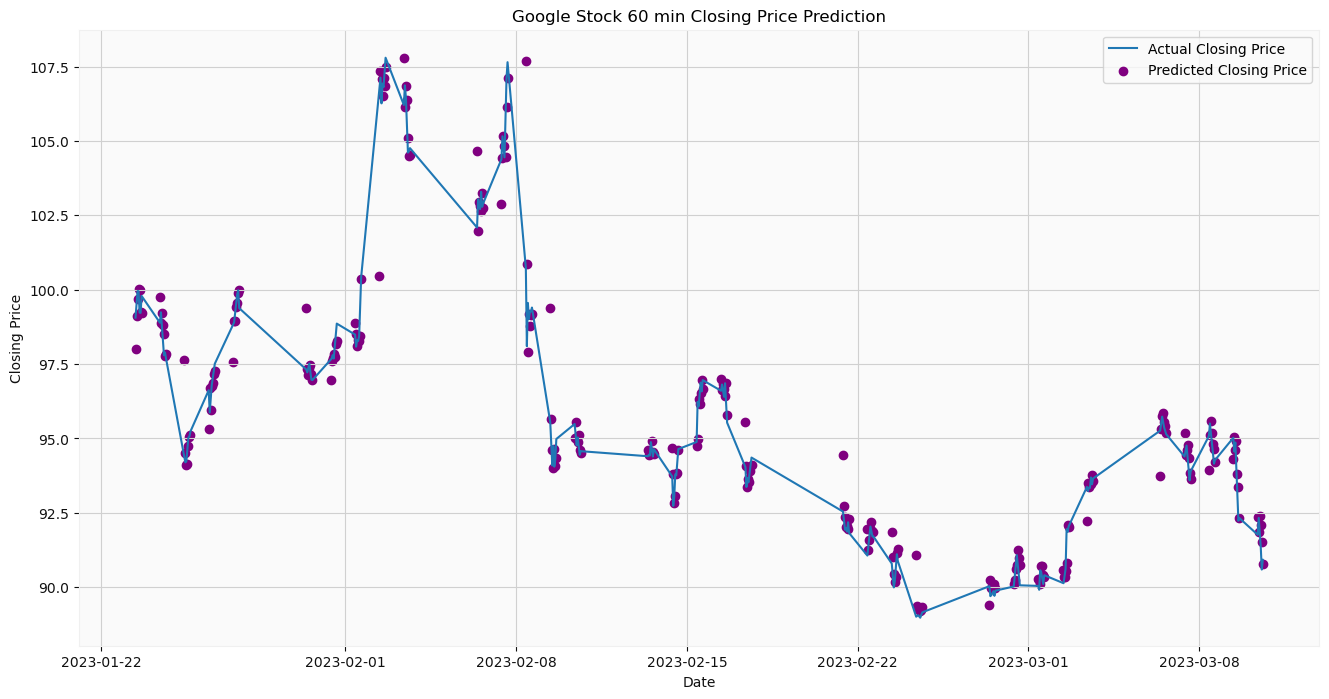

Close        EMA        RSI      MACD     Target  \
Datetime                                                                    
2023-03-10 10:30:00  92.324997  93.571429  39.562627 -0.354378  91.959999   
2023-03-10 11:30:00  91.959999  93.417960  37.339704 -0.431341  91.349998   
2023-03-10 12:30:00  91.349998  93.221011  33.910466 -0.535385  90.589996   
2023-03-10 13:30:00  90.589996  92.970438  30.190291 -0.671427  90.916801   
2023-03-10 14:30:00  90.916801  92.774854  33.565362 -0.744290  90.629997   

                     Predicted Closing Price  
Datetime                                      
2023-03-10 10:30:00                91.847229  
2023-03-10 11:30:00                92.385834  
2023-03-10 12:30:00                92.079391  
2023-03-10 13:30:00                91.515457  
2023-03-10 14:30:00                90.781067

In [144]:
# Plot the predicted over the actual closing price
plt.figure(figsize=(16,8))
plt.plot(df.index[int(len(data)*0.8):], y_test, label='Actual Closing Price')
plt.scatter(df.index[int(len(data)*0.8):], predictions, color = 'purple', label='Predicted Closing Price')
plt.title('Google Stock 60 min Closing Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

#displaying the predicted values
df.tail()

### Conclusions:

Machine learning has emerged as a powerful tool for predicting stock prices. This report highlights the range of models available for this task, emphasizing the importance of careful analysis in choosing the best model for the job. It is crucial to consider factors such as the size and quality of the dataset, the nature of the problem, and the model's accuracy, interpretability, and computational efficiency. With the right model, machine learning can provide valuable insights into stock market trends and help investors make informed decisions.

"K-means clustering has proven to be a valuable tool for stock classification, helping to identify stocks with similar characteristics and differentiate them from those that are dissimilar. The assumption that stocks belonging to different industries are inherently different has been challenged, as evidenced by the results obtained from the Dow Jones dataset, indicating that there may be other factors at play that affect stock behavior. The ability of k-means clustering to uncover these nuances and ensure proper classification is invaluable in the complex task of portfolio diversification. By utilizing k-means, investors can gain a more nuanced understanding of the market and make more informed investment decisions."

The K-Nearest Neighbors algorithm was trained on historical data using Euclidean distance to identify the k-nearest neighbors of a new data point in the feature space. The choice of the appropriate value for k and selection of appropriate parameters were critical in improving the model's performance. The model demonstrated impressive predictive accuracy in estimating future 'target closing prices,' especially when trained on a 60-minute dataset. The model yielded a MSE of 1.29 and a MAE of 0.79. These results underscore the potential of K-Nearest Neighbors as a reliable tool for stock price prediction, provided careful consideration is given to parameter selection and choice of training data.

LSTM used the power of Recurrent Neural Networks to capture the temporal dependencies in time series data. The memory or state of previous inputs in RNNs allowed LSTM to recognize sequential patterns and make accurate predictions based on the past price movements during training. This is particularly advantageous in stock price prediction, where past price movements are often indicative of future movements. Additionally, LSTM can capture long-term dependencies, which is critical in predicting stock prices since they are influenced by a wide range of factors that can have a long-term impact. The LSTM results were once again particularly impressive when it was applied to the 60 minutes data using 30 epochs, producing a MSE of 0.90 and a MAE of 0.54. 

While the choice of machine learning model is an important aspect of stock price prediction, it is not the only factor that traders need to consider to gain an edge. In addition to model selection, traders must also take into account other critical factors, such as the cost of each trade, live feed data costs, and the often-neglected impact of slippage. Slippage refers to the difference between the price at which a buy or sell order is submitted and the price at which it is filled. Even the best-performing system may fall short in real-world trading situations where trade orders are not guaranteed to be filled. Therefore, it is essential to carefully evaluate all the factors that can impact trading performance and to continually refine and adjust trading strategies to improve overall profitability.